### Import dependencies

In [3]:
# %load_ext autotime


import os
import cv2
from IPython.display import display_html, display
from PIL import Image as PILImage
from utils import display_borderless_tables

from img2table.document import Image
from img2table.ocr import TesseractOCR, PaddleOCR

### Borderless table extraction

An algorithm for identification and extraction of borderless tables (i.e not fully bordered). However, the detection might not be as reliable as the one for bordered tables, especially for tables with multi-line cells.

#### Image used
<img src="data/borderless.jpg" width="425" height="550">

In [4]:
from img2table.document import Image
import pypdfium2 as pdfium
from PIL import Image as PILImage
from io import BytesIO

pdf_path = "crime_pdfs/1.pdf"

# Render page 0 at higher resolution
doc = pdfium.PdfDocument(pdf_path)
page = doc[0]
bitmap = page.render(scale=2)  # increase scale for better OCR
pil_img = bitmap.to_pil()

# Convert to bytes and create img2table Image
buf = BytesIO()
pil_img.save(buf, format="PNG")
img = Image(src=buf.getvalue())

# Now you can do:
# tables = img.extract_tables(ocr=..., borderless_tables=True)


In [5]:
# img = Image("data/borderless.jpg")
tesseract = TesseractOCR()

# Extract tables with Tesseract and PaddleOCR
tables = img.extract_tables(ocr=tesseract, borderless_tables=True)

tables[0].df

tesseract 5.5.1
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.50 : libtiff 4.7.0 : zlib 1.2.12 : libwebp 1.6.0 : libopenjp2 2.5.3
 Found NEON
 Found libarchive 3.8.1 zlib/1.2.12 liblzma/5.8.1 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.7 expat/expat_2.7.1 CommonCrypto/system libb2/system
 Found libcurl/8.7.1 SecureTransport (LibreSSL/3.3.6) zlib/1.2.12 nghttp2/1.67.1


,0,1,2,3,4,5,6,7,8
0,Sr.,Crime Heads,Current,Previous,Current,%,Previous,%,None
1,No.,None,Month,Month,Year,of,Year,of,Difference
2,None,None,01.01.2018,01.12.2017,01.01.2018,Detec-,01.01.2017,Detec-,In
3,None,None,To,To,To,tion,To,tion,Reg.
4,None,None,31.01.2018,31.12.2017,31.01.2018,None,31.01.2017,None,None
5,None,None,R\nD,R\nD,R\nD,None,R,None,None


In [10]:
tables[1].df



,0,1,2,3,4,5,6,7,8,9,10,11,12
0,None,Murder,10,None,7,None,10,None,90,13,12,92,None
1,None,Att.to.C.Murder,23,21,16,12,23,21,91,19,17,89,None
2,None,Dacoity,None,None,None,None,None,None,None,None,None,100,None
3,None,Robbery (Excluding Chain Snatchir,88,65,84,55,88,65,74,74,45,61,14
4,None,Robbery -Chain Snatching,10,None,12,None,10,None,50,14,None,50,None
5,None,Extortion,20,16,21,15,20,16,80,None,None,89,ll
6,None,H.B.T Day / Night,220,3,205,49,220,B,33,214,55,26,None
7,None,Thefts,539,144,643,126,539,144,27,586,137,23,47
8,None,M.V. Thefts.,344,53,376,44,344,53,15,272,43,16,None
9,10,Hurt,481,361,377,272,481,361,75,380,278,B,101


### Examples

Below are several examples of borderless table extraction.<br>
As for bordered tables, the extraction of merged cells or multi-level headers is also supported.

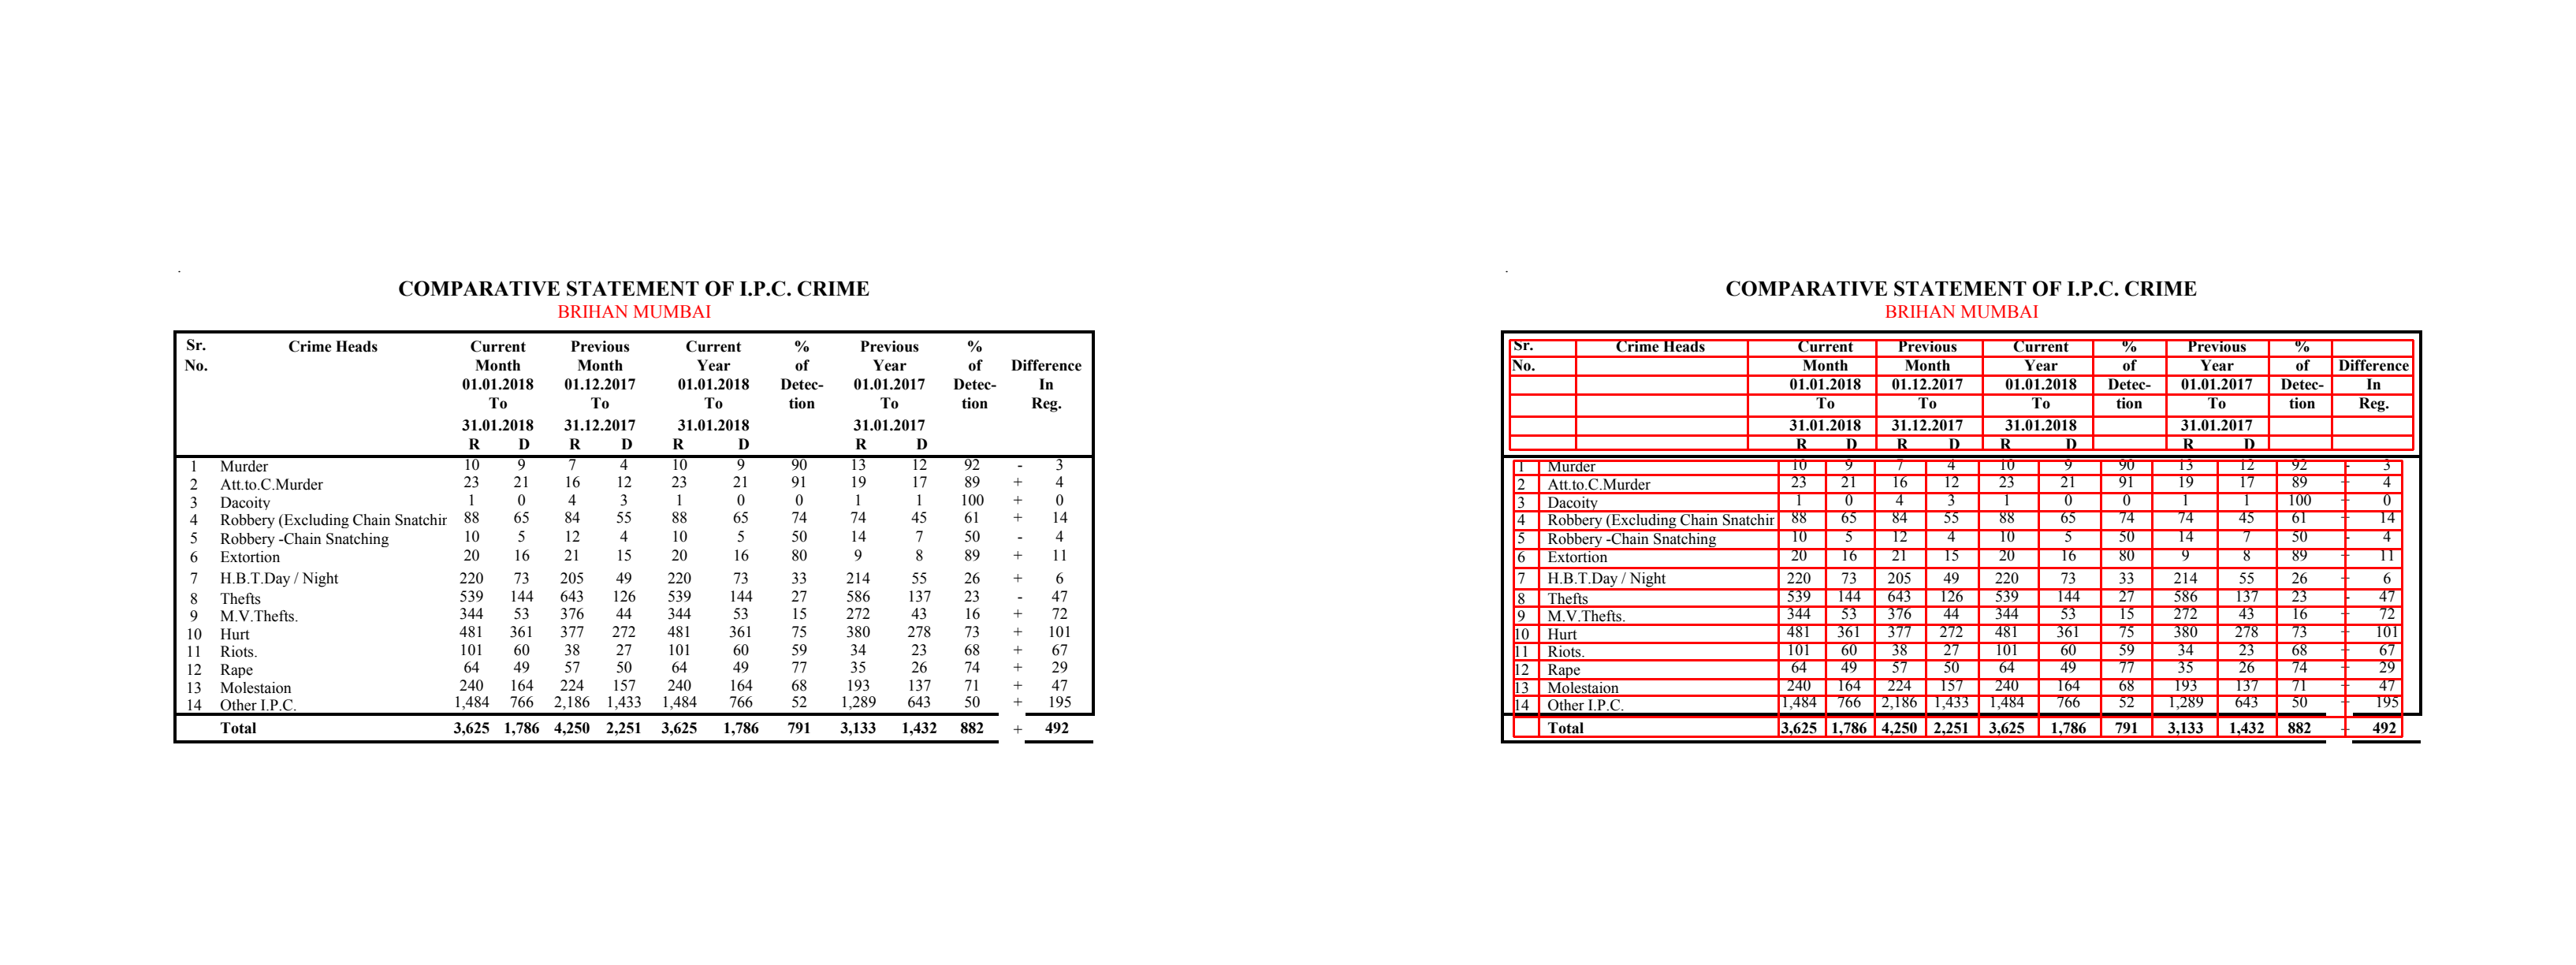

In [8]:
# for img_path in os.listdir(pdf_path):
# img = Image(f"data/borderless/{img_path}")
display_img = display_borderless_tables(img=img, ocr=tesseract)

display(PILImage.fromarray(display_img))
display_html("<hr>", raw=True)

In [12]:
import cv2
import pypdfium2 as pdfium
from io import BytesIO
from PIL import Image as PILImage
from urllib.parse import urlparse

from img2table.document import Image
from img2table.ocr import TesseractOCR, AzureOCR
import importlib
import utils
importlib.reload(utils)
from utils import render_table_grid

import config

# 1) Render first page to image
doc = pdfium.PdfDocument("crime_pdfs/1.pdf")
page = doc[0]
bitmap = page.render(scale=2)
pil_img = bitmap.to_pil()

buf = BytesIO()
pil_img.save(buf, format="PNG")
img = Image(src=buf.getvalue())

# 2) Draw black grid lines using Tesseract structure
tesseract = TesseractOCR()
grid_img = render_table_grid(img, tesseract, color=(0, 0, 0), thickness=2, borderless_tables=True)

# 3) Convert grid image back to img2table Image
_, png = cv2.imencode(".png", grid_img)
img_with_lines = Image(src=png.tobytes())

# 4) Run Azure OCR on the grid image
parsed = urlparse(config.layout_url)
endpoint = f"{parsed.scheme}://{parsed.netloc}/"
key = config.layout_key
azure = AzureOCR(endpoint=endpoint, subscription_key=key)

tables = img_with_lines.extract_tables(ocr=azure, borderless_tables=False)
tables


tesseract 5.5.1
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.50 : libtiff 4.7.0 : zlib 1.2.12 : libwebp 1.6.0 : libopenjp2 2.5.3
 Found NEON
 Found libarchive 3.8.1 zlib/1.2.12 liblzma/5.8.1 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.7 expat/expat_2.7.1 CommonCrypto/system libb2/system
 Found libcurl/8.7.1 SecureTransport (LibreSSL/3.3.6) zlib/1.2.12 nghttp2/1.67.1


ComputerVisionOcrErrorException: Operation returned an invalid status code 'PermissionDenied'